In [1]:
#-*- coding:utf-8 -*-
import os
import numpy as np
import numpy.random as rd
import pandas as pd
from scipy import stats as st
import math
import matplotlib.pyplot as plt

os.chdir("..")
home_dir = os.getcwd()
os.chdir("src")
from CRP import crp
os.chdir(home_dir)

In [2]:
seed = 0
n = [200, 150, 150] #各データ数
K = 3 #潜在変数の数
D = 2 #次元

#mu:D次元
mu_true = np.array(
    [[0.2, 0.5],
     [1.2, 0.5],
     [2.0, 0.5]])

#sigma: D×D次元
sigma_true = np.array(
    [[[0.1,  0.085], [0.085, 0.1]],
     [[0.1, -0.085], [-0.085, 0.1]],
     [[0.1,  0.085], [0.085, 0.1]]
    ])

rd.seed(seed)
org_data = None
for i in range(K):
    #k_0 に属するデータを生成
    if org_data is None:
        org_data = np.c_[st.multivariate_normal.rvs(mean=mu_true[i], cov=sigma_true[i], size=n[i]), np.ones(n[i])*i]
        
    #k_1, k_2に属するデータを生成し、結合する
    else:
        tmp_data = np.c_[st.multivariate_normal.rvs(mean=mu_true[i], cov=sigma_true[i], size=n[i]), np.ones(n[i])*i]
        org_data = np.r_[org_data, tmp_data]

#print(org_data)

In [3]:
x = org_data[:,:2].copy()

In [4]:
class DPM:
    def __init__(self, x, alpha, mu0, beta, nu, S):
        self.x = x
        self.num_samples = len(x)
        
        #ハイパーパラメータ
        self.alpha = alpha
        self.mu0 = mu0
        self.beta = beta
        self.nu = nu
        self.S = S
        
        #初期設定
        self.s, self.n_ = crp(alpha, self.num_samples) #潜在変数と各クラスタに所属する総数
        self.s_hat = self.s.copy() #推定した潜在変数
        self.n_hat = self.n_.copy() #推定した各クラスタに所属する総数
        self.c = len(self.n_.keys()) #クラスタ数
        self.c_hat = self.c #更新毎の推定したクラスタ数
        self.d = x.shape[1] #データの次元
        
        #θ(mu, Lambda)の初期化
        self.mu = {}
        self.Lambda = {}
        for i in range(self.c):
            mu_i, Lambda_i = self.calc_params(i, x, self.s, self.n_, mu0, beta, nu, S)
            self.mu[i] = mu_i
            self.Lambda[i] = Lambda_i
        
        self.mu_hat = self.mu.copy() #推定したパラーメ:μ
        self.Lambda_hat = self.Lambda.copy() #推定したパラメータ: Λ
        
        #計算結果格納用
        self.log_post_prob = self.calc_post_prob(x, self.s, self.c, self.n_, self.mu, self.Lambda, alpha, beta, self.num_samples, mu0, nu, S)
        self.prob_max = self.log_post_prob #事後確率最大用
        
       
    def Gibbs_sampling(self):
        '''
        ギブスサンプリングを実行する
        '''
        xs = np.c_[self.x, self.s]
        
        #任意の1つのデータを選択
        del_num = rd.randint(self.num_samples)
        
        #該当するデータを抽出
        del_xs =  xs[del_num]
        del_x = del_xs[:2].copy()
        del_s = int(del_xs[2].copy())
        
        #該当するクラスタの総数を1減らす
        self.n_[del_s] -= 1
        
        #空きクラスタが発生した場合は、クラスタ数とパラメータのインデックスを更新する
        if self.n_[del_s] == 0:
            self.c -= 1
            del self.n_[del_s]
            del self.mu[del_s]
            del self.Lambda[del_s]
            new_keys = [i for i in range(self.c)]
            self.n_ = {key:value for key, value in zip(new_keys, self.n_.values())}
            self.mu = {key:value for key, value in zip(new_keys, self.mu.values())}
            self.Lambda = {key:value for key, value in zip(new_keys, self.Lambda.values())}
            self.s = [s - 1 if s > del_s else s for s in self.s]
        
        #s_kの値を確率的に決める
        p_s_k = np.zeros(self.c + 1)
        #既存の各クラスに対して確率(p(s_k))を計算する
        for i in range(self.c):
            prob = (self.n_[i]/(self.num_samples - 1 + self.alpha)) \
                    * st.multivariate_normal.pdf(del_x, self.mu[i], np.linalg.inv(self.Lambda[i]))
            p_s_k[i] = prob
        
        #新規のクラスタに対して確率を計算する
        #基底分布(正規-ウィシャート分布)として確率を計算する
        #計算に必要な要素を計算する
        xk_mu0 = (del_x - self.mu0)[:, np.newaxis]
        S_b_inv = np.linalg.inv(self.S) + self.beta/(1+self.beta) * np.dot(xk_mu0, xk_mu0.T)
        S_b = np.linalg.inv(S_b_inv)
        A = (self.beta / ((1 + self.beta) * np.pi)) ** (self.d/2)
        B = np.linalg.det(S_b)**((self.nu+1)/2) * math.gamma((self.nu+1)/2)
        C = np.linalg.det(self.S)**(self.nu/2) * math.gamma((self.nu+1-self.d)/2)

        #確率を計算する
        p_tmp = A * B / C #p269 式(12.35)
        prob = self.alpha / (self.num_samples - 1 + self.alpha) * p_tmp
        p_s_k[-1] = prob
        p_s_k = p_s_k / np.sum(p_s_k) #正規化
        
        #s_kの値を確率的にクラスタを決める
        judge = rd.random() #0-1の範囲で乱数を取得
        p_sum = 0
        s_k = 0
        for i, p in enumerate(p_s_k):
            p_sum += p
            if judge < p_sum:
                s_k = i
                break
        
        #s_kの値を更新する
        self.s[del_num] = s_k
        
        #新規クラスタが発生した場合は、総クラスタ数と所属パターン数, パラメータを更新する
        if s_k == self.c:
            self.n_[s_k] = 1
            self.c += 1
            mu_new, Lambda_new = self.calc_params(s_k, self.x, self.s, self.n_, mu0, beta, nu, S)
            self.mu[s_k] = mu_new
            self.Lambda[s_k] = Lambda_new
        
        #既存のクラスタに更新された場合は、所属パターン数を1増やす
        else:
            self.n_[s_k] += 1
        
        #パラメータθ(μ,Λ)の更新(更新があったクラスタのみ)
        #*注意*:空きクラスタになる→既存クラスに所属→空きクラスタ(del_s)のパラメータは更新しない
        if del_s != s_k:
            for c_num in [del_s, s_k]:
                if del_s not in self.n_.keys():
                    continue
                mu_i, Lambda_i = self.calc_params(c_num, self.x, self.s, self.n_, self.mu0, self.beta, self.nu, self.S)
                self.mu[c_num] = mu_i
                self.Lambda[c_num] = Lambda_i
        
        #事後確率:p(s,θ|x)(対数)を求める
        self.log_post_prob = self.calc_post_prob(self.x, self.s, self.c, self.n_, self.mu, self.Lambda, self.alpha, self.beta, self.num_samples, self.mu0, self.nu, self.S)
        
    
    def update(self, min_step=10000, stop_count=1000):
        '''
        #ギブスサンプリングを繰り返し、更新されない状態が続いた時打ち切る
        #最低限の繰り返し回数
        #stop_count:更新されない回数が何回続いたら処理を打ち切るか指定するパラメータ
        '''
        update = True
        count = 0
        step = 1
        while update:
            print("step:",step)
            #ギブスサンプリングを実行する
            self.Gibbs_sampling()
            
            #最低限の繰り返し処理
            if step < min_step:
                if self.prob_max < self.log_post_prob:
                    #更新する
                    self.prob_max = self.log_post_prob.copy()
                    self.s_hat = self.s.copy()
                    self.c_hat = self.c
                    self.mu_hat = self.mu.copy()
                    self.Lambda_hat = self.Lambda.copy()
                    self.n_hat = self.n_.copy() 
                step += 1
                continue
            
            #処理の打ち切り判定
            if self.prob_max <= self.log_post_prob:
                #更新する
                self.prob_max = self.log_post_prob.copy()
                self.s_hat = self.s.copy()
                self.c_hat = self.c
                self.mu_hat = self.mu.copy()
                self.Lambda_hat = self.Lambda.copy()
                self.n_hat = self.n_.copy()
                count = 0
                
            else:   
                count +=1
                if count == stop_count:
                    break
            
            step += 1
    
    #計算に必要な関数の定義
    def calc_params(self, c_num, x, s, n_, mu0, beta, nu, S):
        '''
        各クラスタでパラメータを求める
        c_num:クラスタ番号を指定
        '''
        xs = np.c_[x, s] #パターンと潜在変数を結合したデータを作成

        #x_：クラスタに所属するデータ全体の平均を計算する
        x_ = np.mean(xs[xs[:,2]==c_num], axis=0)[:2]

        #最尤推定値:μ_cを計算する
        mu_c = (n_[c_num] * x_ + beta * mu0) / (n_[c_num] + beta)

        #Sqを計算する
        Sq_inv = np.zeros(S.shape)
        for xs_k in xs:
            if xs_k[2] == c_num:
                vector = (xs_k[:2] - x_)[:, np.newaxis]
                Sq_inv += np.dot(vector, vector.T)
        vector2 = (x_ - mu0)[:, np.newaxis]
        Sq_inv = np.linalg.inv(S) + ((n_[c_num] * beta)/(n_[c_num] + beta)) * np.dot(vector2, vector2.T) 
        Sq = np.linalg.inv(Sq_inv)

        #ν_cを計算する
        nu_c = nu + n_[c_num]

        #Λ_iをウィシャート分布から生成する
        Lambda_i = st.wishart.rvs(df=nu_c, scale=Sq)

        #Λ_cを計算する
        Lambda_c = (n_[c_num] + beta) * Lambda_i

        #μ_iを計算する
        mu_i = st.multivariate_normal.rvs(mu_c, np.linalg.inv(Lambda_c))

        return mu_i, Lambda_i    

    
    def calc_post_prob(self, x, s, c, n_, mu, Lambda, alpha, beta, n, mu0, nu, S):
        '''
        事後確率(対数)を計算する
        '''
        log_p = 0
        log_p += c * np.log(alpha)

        for i in range(c):
            for n in range(n_[i]-1):
                log_p += np.log(n+1)

            for x_k, s_k in zip(x, s):
                if s_k == i:
                    p_x = st.multivariate_normal.pdf(x_k, mu[i], np.linalg.inv(Lambda[i]))
                    log_p += np.log(p_x)

            #G_0(θ_i)を計算する
            p_N = st.multivariate_normal.pdf(mu[i], mu0, np.linalg.inv(beta*Lambda[i]))
            p_W = st.wishart.pdf(Lambda[i], df=nu, scale=S)
            G0_theta = p_N * p_W
            log_p += np.log(G0_theta)

        for i in range(n):
            log_p -= np.log(i+alpha)

        return log_p

In [5]:
#ハイパーパラメータ
alpha = 1.0
mu0 = np.mean(x, axis=0)#全パターンの平均ベクトル
beta = 1 / 3
nu = 15
S = np.array([[0.1, 0],
              [0, 0.1]])

In [6]:
dpm = DPM(x, alpha, mu0, beta, nu, S)

In [7]:
dpm.update(min_step=10000, stop_count=100)

step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
step: 9
step: 10
step: 11
step: 12
step: 13
step: 14
step: 15
step: 16
step: 17
step: 18
step: 19
step: 20
step: 21
step: 22
step: 23
step: 24
step: 25
step: 26
step: 27
step: 28
step: 29
step: 30
step: 31
step: 32
step: 33
step: 34
step: 35
step: 36
step: 37
step: 38
step: 39
step: 40
step: 41
step: 42
step: 43
step: 44
step: 45
step: 46
step: 47
step: 48
step: 49
step: 50
step: 51
step: 52
step: 53
step: 54
step: 55
step: 56
step: 57
step: 58
step: 59
step: 60
step: 61
step: 62
step: 63
step: 64
step: 65
step: 66
step: 67
step: 68
step: 69
step: 70
step: 71
step: 72
step: 73
step: 74
step: 75
step: 76
step: 77
step: 78
step: 79
step: 80
step: 81
step: 82
step: 83
step: 84
step: 85
step: 86
step: 87
step: 88
step: 89
step: 90
step: 91
step: 92
step: 93
step: 94
step: 95
step: 96
step: 97
step: 98
step: 99
step: 100
step: 101
step: 102
step: 103
step: 104
step: 105
step: 106
step: 107
step: 108
step: 109
step: 110
step: 11

step: 833
step: 834
step: 835
step: 836
step: 837
step: 838
step: 839
step: 840
step: 841
step: 842
step: 843
step: 844
step: 845
step: 846
step: 847
step: 848
step: 849
step: 850
step: 851
step: 852
step: 853
step: 854
step: 855
step: 856
step: 857
step: 858
step: 859
step: 860
step: 861
step: 862
step: 863
step: 864
step: 865
step: 866
step: 867
step: 868
step: 869
step: 870
step: 871
step: 872
step: 873
step: 874
step: 875
step: 876
step: 877
step: 878
step: 879
step: 880
step: 881
step: 882
step: 883
step: 884
step: 885
step: 886
step: 887
step: 888
step: 889
step: 890
step: 891
step: 892
step: 893
step: 894
step: 895
step: 896
step: 897
step: 898
step: 899
step: 900
step: 901
step: 902
step: 903
step: 904
step: 905
step: 906
step: 907
step: 908
step: 909
step: 910
step: 911
step: 912
step: 913
step: 914
step: 915
step: 916
step: 917
step: 918
step: 919
step: 920
step: 921
step: 922
step: 923
step: 924
step: 925
step: 926
step: 927
step: 928
step: 929
step: 930
step: 931
step: 932


step: 1594
step: 1595
step: 1596
step: 1597
step: 1598
step: 1599
step: 1600
step: 1601
step: 1602
step: 1603
step: 1604
step: 1605
step: 1606
step: 1607
step: 1608
step: 1609
step: 1610
step: 1611
step: 1612
step: 1613
step: 1614
step: 1615
step: 1616
step: 1617
step: 1618
step: 1619
step: 1620
step: 1621
step: 1622
step: 1623
step: 1624
step: 1625
step: 1626
step: 1627
step: 1628
step: 1629
step: 1630
step: 1631
step: 1632
step: 1633
step: 1634
step: 1635
step: 1636
step: 1637
step: 1638
step: 1639
step: 1640
step: 1641
step: 1642
step: 1643
step: 1644
step: 1645
step: 1646
step: 1647
step: 1648
step: 1649
step: 1650
step: 1651
step: 1652
step: 1653
step: 1654
step: 1655
step: 1656
step: 1657
step: 1658
step: 1659
step: 1660
step: 1661
step: 1662
step: 1663
step: 1664
step: 1665
step: 1666
step: 1667
step: 1668
step: 1669
step: 1670
step: 1671
step: 1672
step: 1673
step: 1674
step: 1675
step: 1676
step: 1677
step: 1678
step: 1679
step: 1680
step: 1681
step: 1682
step: 1683
step: 1684

step: 2339
step: 2340
step: 2341
step: 2342
step: 2343
step: 2344
step: 2345
step: 2346
step: 2347
step: 2348
step: 2349
step: 2350
step: 2351
step: 2352
step: 2353
step: 2354
step: 2355
step: 2356
step: 2357
step: 2358
step: 2359
step: 2360
step: 2361
step: 2362
step: 2363
step: 2364
step: 2365
step: 2366
step: 2367
step: 2368
step: 2369
step: 2370
step: 2371
step: 2372
step: 2373
step: 2374
step: 2375
step: 2376
step: 2377
step: 2378
step: 2379
step: 2380
step: 2381
step: 2382
step: 2383
step: 2384
step: 2385
step: 2386
step: 2387
step: 2388
step: 2389
step: 2390
step: 2391
step: 2392
step: 2393
step: 2394
step: 2395
step: 2396
step: 2397
step: 2398
step: 2399
step: 2400
step: 2401
step: 2402
step: 2403
step: 2404
step: 2405
step: 2406
step: 2407
step: 2408
step: 2409
step: 2410
step: 2411
step: 2412
step: 2413
step: 2414
step: 2415
step: 2416
step: 2417
step: 2418
step: 2419
step: 2420
step: 2421
step: 2422
step: 2423
step: 2424
step: 2425
step: 2426
step: 2427
step: 2428
step: 2429

step: 3085
step: 3086
step: 3087
step: 3088
step: 3089
step: 3090
step: 3091
step: 3092
step: 3093
step: 3094
step: 3095
step: 3096
step: 3097
step: 3098
step: 3099
step: 3100
step: 3101
step: 3102
step: 3103
step: 3104
step: 3105
step: 3106
step: 3107
step: 3108
step: 3109
step: 3110
step: 3111
step: 3112
step: 3113
step: 3114
step: 3115
step: 3116
step: 3117
step: 3118
step: 3119
step: 3120
step: 3121
step: 3122
step: 3123
step: 3124
step: 3125
step: 3126
step: 3127
step: 3128
step: 3129
step: 3130
step: 3131
step: 3132
step: 3133
step: 3134
step: 3135
step: 3136
step: 3137
step: 3138
step: 3139
step: 3140
step: 3141
step: 3142
step: 3143
step: 3144
step: 3145
step: 3146
step: 3147
step: 3148
step: 3149
step: 3150
step: 3151
step: 3152
step: 3153
step: 3154
step: 3155
step: 3156
step: 3157
step: 3158
step: 3159
step: 3160
step: 3161
step: 3162
step: 3163
step: 3164
step: 3165
step: 3166
step: 3167
step: 3168
step: 3169
step: 3170
step: 3171
step: 3172
step: 3173
step: 3174
step: 3175

step: 3830
step: 3831
step: 3832
step: 3833
step: 3834
step: 3835
step: 3836
step: 3837
step: 3838
step: 3839
step: 3840
step: 3841
step: 3842
step: 3843
step: 3844
step: 3845
step: 3846
step: 3847
step: 3848
step: 3849
step: 3850
step: 3851
step: 3852
step: 3853
step: 3854
step: 3855
step: 3856
step: 3857
step: 3858
step: 3859
step: 3860
step: 3861
step: 3862
step: 3863
step: 3864
step: 3865
step: 3866
step: 3867
step: 3868
step: 3869
step: 3870
step: 3871
step: 3872
step: 3873
step: 3874
step: 3875
step: 3876
step: 3877
step: 3878
step: 3879
step: 3880
step: 3881
step: 3882
step: 3883
step: 3884
step: 3885
step: 3886
step: 3887
step: 3888
step: 3889
step: 3890
step: 3891
step: 3892
step: 3893
step: 3894
step: 3895
step: 3896
step: 3897
step: 3898
step: 3899
step: 3900
step: 3901
step: 3902
step: 3903
step: 3904
step: 3905
step: 3906
step: 3907
step: 3908
step: 3909
step: 3910
step: 3911
step: 3912
step: 3913
step: 3914
step: 3915
step: 3916
step: 3917
step: 3918
step: 3919
step: 3920

step: 4575
step: 4576
step: 4577
step: 4578
step: 4579
step: 4580
step: 4581
step: 4582
step: 4583
step: 4584
step: 4585
step: 4586
step: 4587
step: 4588
step: 4589
step: 4590
step: 4591
step: 4592
step: 4593
step: 4594
step: 4595
step: 4596
step: 4597
step: 4598
step: 4599
step: 4600
step: 4601
step: 4602
step: 4603
step: 4604
step: 4605
step: 4606
step: 4607
step: 4608
step: 4609
step: 4610
step: 4611
step: 4612
step: 4613
step: 4614
step: 4615
step: 4616
step: 4617
step: 4618
step: 4619
step: 4620
step: 4621
step: 4622
step: 4623
step: 4624
step: 4625
step: 4626
step: 4627
step: 4628
step: 4629
step: 4630
step: 4631
step: 4632
step: 4633
step: 4634
step: 4635
step: 4636
step: 4637
step: 4638
step: 4639
step: 4640
step: 4641
step: 4642
step: 4643
step: 4644
step: 4645
step: 4646
step: 4647
step: 4648
step: 4649
step: 4650
step: 4651
step: 4652
step: 4653
step: 4654
step: 4655
step: 4656
step: 4657
step: 4658
step: 4659
step: 4660
step: 4661
step: 4662
step: 4663
step: 4664
step: 4665

step: 5321
step: 5322
step: 5323
step: 5324
step: 5325
step: 5326
step: 5327
step: 5328
step: 5329
step: 5330
step: 5331
step: 5332
step: 5333
step: 5334
step: 5335
step: 5336
step: 5337
step: 5338
step: 5339
step: 5340
step: 5341
step: 5342
step: 5343
step: 5344
step: 5345
step: 5346
step: 5347
step: 5348
step: 5349
step: 5350
step: 5351
step: 5352
step: 5353
step: 5354
step: 5355
step: 5356
step: 5357
step: 5358
step: 5359
step: 5360
step: 5361
step: 5362
step: 5363
step: 5364
step: 5365
step: 5366
step: 5367
step: 5368
step: 5369
step: 5370
step: 5371
step: 5372
step: 5373
step: 5374
step: 5375
step: 5376
step: 5377
step: 5378
step: 5379
step: 5380
step: 5381
step: 5382
step: 5383
step: 5384
step: 5385
step: 5386
step: 5387
step: 5388
step: 5389
step: 5390
step: 5391
step: 5392
step: 5393
step: 5394
step: 5395
step: 5396
step: 5397
step: 5398
step: 5399
step: 5400
step: 5401
step: 5402
step: 5403
step: 5404
step: 5405
step: 5406
step: 5407
step: 5408
step: 5409
step: 5410
step: 5411

step: 6067
step: 6068
step: 6069
step: 6070
step: 6071
step: 6072
step: 6073
step: 6074
step: 6075
step: 6076
step: 6077
step: 6078
step: 6079
step: 6080
step: 6081
step: 6082
step: 6083
step: 6084
step: 6085
step: 6086
step: 6087
step: 6088
step: 6089
step: 6090
step: 6091
step: 6092
step: 6093
step: 6094
step: 6095
step: 6096
step: 6097
step: 6098
step: 6099
step: 6100
step: 6101
step: 6102
step: 6103
step: 6104
step: 6105
step: 6106
step: 6107
step: 6108
step: 6109
step: 6110
step: 6111
step: 6112
step: 6113
step: 6114
step: 6115
step: 6116
step: 6117
step: 6118
step: 6119
step: 6120
step: 6121
step: 6122
step: 6123
step: 6124
step: 6125
step: 6126
step: 6127
step: 6128
step: 6129
step: 6130
step: 6131
step: 6132
step: 6133
step: 6134
step: 6135
step: 6136
step: 6137
step: 6138
step: 6139
step: 6140
step: 6141
step: 6142
step: 6143
step: 6144
step: 6145
step: 6146
step: 6147
step: 6148
step: 6149
step: 6150
step: 6151
step: 6152
step: 6153
step: 6154
step: 6155
step: 6156
step: 6157

step: 6812
step: 6813
step: 6814
step: 6815
step: 6816
step: 6817
step: 6818
step: 6819
step: 6820
step: 6821
step: 6822
step: 6823
step: 6824
step: 6825
step: 6826
step: 6827
step: 6828
step: 6829
step: 6830
step: 6831
step: 6832
step: 6833
step: 6834
step: 6835
step: 6836
step: 6837
step: 6838
step: 6839
step: 6840
step: 6841
step: 6842
step: 6843
step: 6844
step: 6845
step: 6846
step: 6847
step: 6848
step: 6849
step: 6850
step: 6851
step: 6852
step: 6853
step: 6854
step: 6855
step: 6856
step: 6857
step: 6858
step: 6859
step: 6860
step: 6861
step: 6862
step: 6863
step: 6864
step: 6865
step: 6866
step: 6867
step: 6868
step: 6869
step: 6870
step: 6871
step: 6872
step: 6873
step: 6874
step: 6875
step: 6876
step: 6877
step: 6878
step: 6879
step: 6880
step: 6881
step: 6882
step: 6883
step: 6884
step: 6885
step: 6886
step: 6887
step: 6888
step: 6889
step: 6890
step: 6891
step: 6892
step: 6893
step: 6894
step: 6895
step: 6896
step: 6897
step: 6898
step: 6899
step: 6900
step: 6901
step: 6902

step: 7558
step: 7559
step: 7560
step: 7561
step: 7562
step: 7563
step: 7564
step: 7565
step: 7566
step: 7567
step: 7568
step: 7569
step: 7570
step: 7571
step: 7572
step: 7573
step: 7574
step: 7575
step: 7576
step: 7577
step: 7578
step: 7579
step: 7580
step: 7581
step: 7582
step: 7583
step: 7584
step: 7585
step: 7586
step: 7587
step: 7588
step: 7589
step: 7590
step: 7591
step: 7592
step: 7593
step: 7594
step: 7595
step: 7596
step: 7597
step: 7598
step: 7599
step: 7600
step: 7601
step: 7602
step: 7603
step: 7604
step: 7605
step: 7606
step: 7607
step: 7608
step: 7609
step: 7610
step: 7611
step: 7612
step: 7613
step: 7614
step: 7615
step: 7616
step: 7617
step: 7618
step: 7619
step: 7620
step: 7621
step: 7622
step: 7623
step: 7624
step: 7625
step: 7626
step: 7627
step: 7628
step: 7629
step: 7630
step: 7631
step: 7632
step: 7633
step: 7634
step: 7635
step: 7636
step: 7637
step: 7638
step: 7639
step: 7640
step: 7641
step: 7642
step: 7643
step: 7644
step: 7645
step: 7646
step: 7647
step: 7648

step: 8304
step: 8305
step: 8306
step: 8307
step: 8308
step: 8309
step: 8310
step: 8311
step: 8312
step: 8313
step: 8314
step: 8315
step: 8316
step: 8317
step: 8318
step: 8319
step: 8320
step: 8321
step: 8322
step: 8323
step: 8324
step: 8325
step: 8326
step: 8327
step: 8328
step: 8329
step: 8330
step: 8331
step: 8332
step: 8333
step: 8334
step: 8335
step: 8336
step: 8337
step: 8338
step: 8339
step: 8340
step: 8341
step: 8342
step: 8343
step: 8344
step: 8345
step: 8346
step: 8347
step: 8348
step: 8349
step: 8350
step: 8351
step: 8352
step: 8353
step: 8354
step: 8355
step: 8356
step: 8357
step: 8358
step: 8359
step: 8360
step: 8361
step: 8362
step: 8363
step: 8364
step: 8365
step: 8366
step: 8367
step: 8368
step: 8369
step: 8370
step: 8371
step: 8372
step: 8373
step: 8374
step: 8375
step: 8376
step: 8377
step: 8378
step: 8379
step: 8380
step: 8381
step: 8382
step: 8383
step: 8384
step: 8385
step: 8386
step: 8387
step: 8388
step: 8389
step: 8390
step: 8391
step: 8392
step: 8393
step: 8394

step: 9049
step: 9050
step: 9051
step: 9052
step: 9053
step: 9054
step: 9055
step: 9056
step: 9057
step: 9058
step: 9059
step: 9060
step: 9061
step: 9062
step: 9063
step: 9064
step: 9065
step: 9066
step: 9067
step: 9068
step: 9069
step: 9070
step: 9071
step: 9072
step: 9073
step: 9074
step: 9075
step: 9076
step: 9077
step: 9078
step: 9079
step: 9080
step: 9081
step: 9082
step: 9083
step: 9084
step: 9085
step: 9086
step: 9087
step: 9088
step: 9089
step: 9090
step: 9091
step: 9092
step: 9093
step: 9094
step: 9095
step: 9096
step: 9097
step: 9098
step: 9099
step: 9100
step: 9101
step: 9102
step: 9103
step: 9104
step: 9105
step: 9106
step: 9107
step: 9108
step: 9109
step: 9110
step: 9111
step: 9112
step: 9113
step: 9114
step: 9115
step: 9116
step: 9117
step: 9118
step: 9119
step: 9120
step: 9121
step: 9122
step: 9123
step: 9124
step: 9125
step: 9126
step: 9127
step: 9128
step: 9129
step: 9130
step: 9131
step: 9132
step: 9133
step: 9134
step: 9135
step: 9136
step: 9137
step: 9138
step: 9139

step: 9794
step: 9795
step: 9796
step: 9797
step: 9798
step: 9799
step: 9800
step: 9801
step: 9802
step: 9803
step: 9804
step: 9805
step: 9806
step: 9807
step: 9808
step: 9809
step: 9810
step: 9811
step: 9812
step: 9813
step: 9814
step: 9815
step: 9816
step: 9817
step: 9818
step: 9819
step: 9820
step: 9821
step: 9822
step: 9823
step: 9824
step: 9825
step: 9826
step: 9827
step: 9828
step: 9829
step: 9830
step: 9831
step: 9832
step: 9833
step: 9834
step: 9835
step: 9836
step: 9837
step: 9838
step: 9839
step: 9840
step: 9841
step: 9842
step: 9843
step: 9844
step: 9845
step: 9846
step: 9847
step: 9848
step: 9849
step: 9850
step: 9851
step: 9852
step: 9853
step: 9854
step: 9855
step: 9856
step: 9857
step: 9858
step: 9859
step: 9860
step: 9861
step: 9862
step: 9863
step: 9864
step: 9865
step: 9866
step: 9867
step: 9868
step: 9869
step: 9870
step: 9871
step: 9872
step: 9873
step: 9874
step: 9875
step: 9876
step: 9877
step: 9878
step: 9879
step: 9880
step: 9881
step: 9882
step: 9883
step: 9884

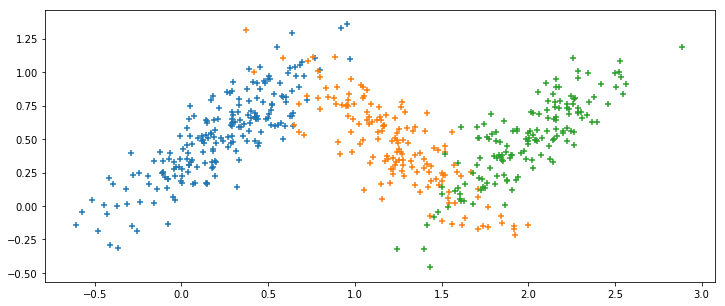

In [8]:
# plot original data        
plt.figure(figsize=(12, 5))
for i in range(K):
    plt.scatter(org_data[org_data[:,2]==i][:,0], org_data[org_data[:,2]==i][:,1], marker="+")
plt.show()

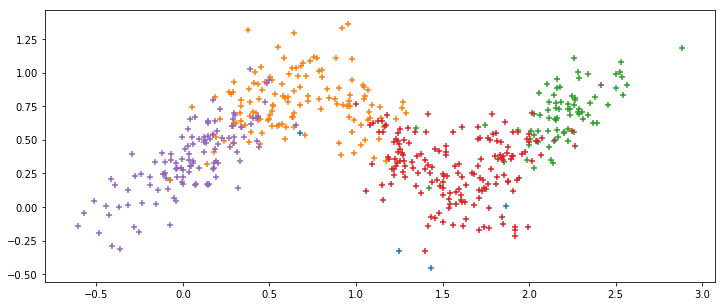

In [9]:
# plot generated data        
plt.figure(figsize=(12, 5))

xs = np.c_[dpm.x, dpm.s_hat]

for i in range(dpm.c_hat+1):
    plt.scatter(xs[xs[:,2]==i][:,0], xs[xs[:,2]==i][:,1], marker="+")
plt.show()

In [10]:
dpm.prob_max

1440.298128810779

In [11]:
dpm.n_hat

{0: 5, 1: 136, 2: 74, 3: 166, 4: 117, 5: 2}

### パラメータを変えてみる

In [12]:
#νを小さくして、分割をされにくくする(νSが小さくなると分割されにくくなる)
alpha = 1.0
mu0 = np.mean(x, axis=0)#全パターンの平均ベクトル
beta = 1 / 3
nu = 10
S = np.array([[0.1, 0],
              [0, 0.1]])

In [13]:
dpm2 = DPM(x, alpha, mu0, beta, nu, S)
dpm2.update(min_step=10000, stop_count=100)

step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
step: 9
step: 10
step: 11
step: 12
step: 13
step: 14
step: 15
step: 16
step: 17
step: 18
step: 19
step: 20
step: 21
step: 22
step: 23
step: 24
step: 25
step: 26
step: 27
step: 28
step: 29
step: 30
step: 31
step: 32
step: 33
step: 34
step: 35
step: 36
step: 37
step: 38
step: 39
step: 40
step: 41
step: 42
step: 43
step: 44
step: 45
step: 46
step: 47
step: 48
step: 49
step: 50
step: 51
step: 52
step: 53
step: 54
step: 55
step: 56
step: 57
step: 58
step: 59
step: 60
step: 61
step: 62
step: 63
step: 64
step: 65
step: 66
step: 67
step: 68
step: 69
step: 70
step: 71
step: 72
step: 73
step: 74
step: 75
step: 76
step: 77
step: 78
step: 79
step: 80
step: 81
step: 82
step: 83
step: 84
step: 85
step: 86
step: 87
step: 88
step: 89
step: 90
step: 91
step: 92
step: 93
step: 94
step: 95
step: 96
step: 97
step: 98
step: 99
step: 100
step: 101
step: 102
step: 103
step: 104
step: 105
step: 106
step: 107
step: 108
step: 109
step: 110
step: 11

step: 832
step: 833
step: 834
step: 835
step: 836
step: 837
step: 838
step: 839
step: 840
step: 841
step: 842
step: 843
step: 844
step: 845
step: 846
step: 847
step: 848
step: 849
step: 850
step: 851
step: 852
step: 853
step: 854
step: 855
step: 856
step: 857
step: 858
step: 859
step: 860
step: 861
step: 862
step: 863
step: 864
step: 865
step: 866
step: 867
step: 868
step: 869
step: 870
step: 871
step: 872
step: 873
step: 874
step: 875
step: 876
step: 877
step: 878
step: 879
step: 880
step: 881
step: 882
step: 883
step: 884
step: 885
step: 886
step: 887
step: 888
step: 889
step: 890
step: 891
step: 892
step: 893
step: 894
step: 895
step: 896
step: 897
step: 898
step: 899
step: 900
step: 901
step: 902
step: 903
step: 904
step: 905
step: 906
step: 907
step: 908
step: 909
step: 910
step: 911
step: 912
step: 913
step: 914
step: 915
step: 916
step: 917
step: 918
step: 919
step: 920
step: 921
step: 922
step: 923
step: 924
step: 925
step: 926
step: 927
step: 928
step: 929
step: 930
step: 931


step: 1593
step: 1594
step: 1595
step: 1596
step: 1597
step: 1598
step: 1599
step: 1600
step: 1601
step: 1602
step: 1603
step: 1604
step: 1605
step: 1606
step: 1607
step: 1608
step: 1609
step: 1610
step: 1611
step: 1612
step: 1613
step: 1614
step: 1615
step: 1616
step: 1617
step: 1618
step: 1619
step: 1620
step: 1621
step: 1622
step: 1623
step: 1624
step: 1625
step: 1626
step: 1627
step: 1628
step: 1629
step: 1630
step: 1631
step: 1632
step: 1633
step: 1634
step: 1635
step: 1636
step: 1637
step: 1638
step: 1639
step: 1640
step: 1641
step: 1642
step: 1643
step: 1644
step: 1645
step: 1646
step: 1647
step: 1648
step: 1649
step: 1650
step: 1651
step: 1652
step: 1653
step: 1654
step: 1655
step: 1656
step: 1657
step: 1658
step: 1659
step: 1660
step: 1661
step: 1662
step: 1663
step: 1664
step: 1665
step: 1666
step: 1667
step: 1668
step: 1669
step: 1670
step: 1671
step: 1672
step: 1673
step: 1674
step: 1675
step: 1676
step: 1677
step: 1678
step: 1679
step: 1680
step: 1681
step: 1682
step: 1683

step: 2339
step: 2340
step: 2341
step: 2342
step: 2343
step: 2344
step: 2345
step: 2346
step: 2347
step: 2348
step: 2349
step: 2350
step: 2351
step: 2352
step: 2353
step: 2354
step: 2355
step: 2356
step: 2357
step: 2358
step: 2359
step: 2360
step: 2361
step: 2362
step: 2363
step: 2364
step: 2365
step: 2366
step: 2367
step: 2368
step: 2369
step: 2370
step: 2371
step: 2372
step: 2373
step: 2374
step: 2375
step: 2376
step: 2377
step: 2378
step: 2379
step: 2380
step: 2381
step: 2382
step: 2383
step: 2384
step: 2385
step: 2386
step: 2387
step: 2388
step: 2389
step: 2390
step: 2391
step: 2392
step: 2393
step: 2394
step: 2395
step: 2396
step: 2397
step: 2398
step: 2399
step: 2400
step: 2401
step: 2402
step: 2403
step: 2404
step: 2405
step: 2406
step: 2407
step: 2408
step: 2409
step: 2410
step: 2411
step: 2412
step: 2413
step: 2414
step: 2415
step: 2416
step: 2417
step: 2418
step: 2419
step: 2420
step: 2421
step: 2422
step: 2423
step: 2424
step: 2425
step: 2426
step: 2427
step: 2428
step: 2429

step: 3084
step: 3085
step: 3086
step: 3087
step: 3088
step: 3089
step: 3090
step: 3091
step: 3092
step: 3093
step: 3094
step: 3095
step: 3096
step: 3097
step: 3098
step: 3099
step: 3100
step: 3101
step: 3102
step: 3103
step: 3104
step: 3105
step: 3106
step: 3107
step: 3108
step: 3109
step: 3110
step: 3111
step: 3112
step: 3113
step: 3114
step: 3115
step: 3116
step: 3117
step: 3118
step: 3119
step: 3120
step: 3121
step: 3122
step: 3123
step: 3124
step: 3125
step: 3126
step: 3127
step: 3128
step: 3129
step: 3130
step: 3131
step: 3132
step: 3133
step: 3134
step: 3135
step: 3136
step: 3137
step: 3138
step: 3139
step: 3140
step: 3141
step: 3142
step: 3143
step: 3144
step: 3145
step: 3146
step: 3147
step: 3148
step: 3149
step: 3150
step: 3151
step: 3152
step: 3153
step: 3154
step: 3155
step: 3156
step: 3157
step: 3158
step: 3159
step: 3160
step: 3161
step: 3162
step: 3163
step: 3164
step: 3165
step: 3166
step: 3167
step: 3168
step: 3169
step: 3170
step: 3171
step: 3172
step: 3173
step: 3174

step: 3831
step: 3832
step: 3833
step: 3834
step: 3835
step: 3836
step: 3837
step: 3838
step: 3839
step: 3840
step: 3841
step: 3842
step: 3843
step: 3844
step: 3845
step: 3846
step: 3847
step: 3848
step: 3849
step: 3850
step: 3851
step: 3852
step: 3853
step: 3854
step: 3855
step: 3856
step: 3857
step: 3858
step: 3859
step: 3860
step: 3861
step: 3862
step: 3863
step: 3864
step: 3865
step: 3866
step: 3867
step: 3868
step: 3869
step: 3870
step: 3871
step: 3872
step: 3873
step: 3874
step: 3875
step: 3876
step: 3877
step: 3878
step: 3879
step: 3880
step: 3881
step: 3882
step: 3883
step: 3884
step: 3885
step: 3886
step: 3887
step: 3888
step: 3889
step: 3890
step: 3891
step: 3892
step: 3893
step: 3894
step: 3895
step: 3896
step: 3897
step: 3898
step: 3899
step: 3900
step: 3901
step: 3902
step: 3903
step: 3904
step: 3905
step: 3906
step: 3907
step: 3908
step: 3909
step: 3910
step: 3911
step: 3912
step: 3913
step: 3914
step: 3915
step: 3916
step: 3917
step: 3918
step: 3919
step: 3920
step: 3921

step: 4576
step: 4577
step: 4578
step: 4579
step: 4580
step: 4581
step: 4582
step: 4583
step: 4584
step: 4585
step: 4586
step: 4587
step: 4588
step: 4589
step: 4590
step: 4591
step: 4592
step: 4593
step: 4594
step: 4595
step: 4596
step: 4597
step: 4598
step: 4599
step: 4600
step: 4601
step: 4602
step: 4603
step: 4604
step: 4605
step: 4606
step: 4607
step: 4608
step: 4609
step: 4610
step: 4611
step: 4612
step: 4613
step: 4614
step: 4615
step: 4616
step: 4617
step: 4618
step: 4619
step: 4620
step: 4621
step: 4622
step: 4623
step: 4624
step: 4625
step: 4626
step: 4627
step: 4628
step: 4629
step: 4630
step: 4631
step: 4632
step: 4633
step: 4634
step: 4635
step: 4636
step: 4637
step: 4638
step: 4639
step: 4640
step: 4641
step: 4642
step: 4643
step: 4644
step: 4645
step: 4646
step: 4647
step: 4648
step: 4649
step: 4650
step: 4651
step: 4652
step: 4653
step: 4654
step: 4655
step: 4656
step: 4657
step: 4658
step: 4659
step: 4660
step: 4661
step: 4662
step: 4663
step: 4664
step: 4665
step: 4666

step: 5323
step: 5324
step: 5325
step: 5326
step: 5327
step: 5328
step: 5329
step: 5330
step: 5331
step: 5332
step: 5333
step: 5334
step: 5335
step: 5336
step: 5337
step: 5338
step: 5339
step: 5340
step: 5341
step: 5342
step: 5343
step: 5344
step: 5345
step: 5346
step: 5347
step: 5348
step: 5349
step: 5350
step: 5351
step: 5352
step: 5353
step: 5354
step: 5355
step: 5356
step: 5357
step: 5358
step: 5359
step: 5360
step: 5361
step: 5362
step: 5363
step: 5364
step: 5365
step: 5366
step: 5367
step: 5368
step: 5369
step: 5370
step: 5371
step: 5372
step: 5373
step: 5374
step: 5375
step: 5376
step: 5377
step: 5378
step: 5379
step: 5380
step: 5381
step: 5382
step: 5383
step: 5384
step: 5385
step: 5386
step: 5387
step: 5388
step: 5389
step: 5390
step: 5391
step: 5392
step: 5393
step: 5394
step: 5395
step: 5396
step: 5397
step: 5398
step: 5399
step: 5400
step: 5401
step: 5402
step: 5403
step: 5404
step: 5405
step: 5406
step: 5407
step: 5408
step: 5409
step: 5410
step: 5411
step: 5412
step: 5413

step: 6070
step: 6071
step: 6072
step: 6073
step: 6074
step: 6075
step: 6076
step: 6077
step: 6078
step: 6079
step: 6080
step: 6081
step: 6082
step: 6083
step: 6084
step: 6085
step: 6086
step: 6087
step: 6088
step: 6089
step: 6090
step: 6091
step: 6092
step: 6093
step: 6094
step: 6095
step: 6096
step: 6097
step: 6098
step: 6099
step: 6100
step: 6101
step: 6102
step: 6103
step: 6104
step: 6105
step: 6106
step: 6107
step: 6108
step: 6109
step: 6110
step: 6111
step: 6112
step: 6113
step: 6114
step: 6115
step: 6116
step: 6117
step: 6118
step: 6119
step: 6120
step: 6121
step: 6122
step: 6123
step: 6124
step: 6125
step: 6126
step: 6127
step: 6128
step: 6129
step: 6130
step: 6131
step: 6132
step: 6133
step: 6134
step: 6135
step: 6136
step: 6137
step: 6138
step: 6139
step: 6140
step: 6141
step: 6142
step: 6143
step: 6144
step: 6145
step: 6146
step: 6147
step: 6148
step: 6149
step: 6150
step: 6151
step: 6152
step: 6153
step: 6154
step: 6155
step: 6156
step: 6157
step: 6158
step: 6159
step: 6160

step: 6817
step: 6818
step: 6819
step: 6820
step: 6821
step: 6822
step: 6823
step: 6824
step: 6825
step: 6826
step: 6827
step: 6828
step: 6829
step: 6830
step: 6831
step: 6832
step: 6833
step: 6834
step: 6835
step: 6836
step: 6837
step: 6838
step: 6839
step: 6840
step: 6841
step: 6842
step: 6843
step: 6844
step: 6845
step: 6846
step: 6847
step: 6848
step: 6849
step: 6850
step: 6851
step: 6852
step: 6853
step: 6854
step: 6855
step: 6856
step: 6857
step: 6858
step: 6859
step: 6860
step: 6861
step: 6862
step: 6863
step: 6864
step: 6865
step: 6866
step: 6867
step: 6868
step: 6869
step: 6870
step: 6871
step: 6872
step: 6873
step: 6874
step: 6875
step: 6876
step: 6877
step: 6878
step: 6879
step: 6880
step: 6881
step: 6882
step: 6883
step: 6884
step: 6885
step: 6886
step: 6887
step: 6888
step: 6889
step: 6890
step: 6891
step: 6892
step: 6893
step: 6894
step: 6895
step: 6896
step: 6897
step: 6898
step: 6899
step: 6900
step: 6901
step: 6902
step: 6903
step: 6904
step: 6905
step: 6906
step: 6907

step: 7564
step: 7565
step: 7566
step: 7567
step: 7568
step: 7569
step: 7570
step: 7571
step: 7572
step: 7573
step: 7574
step: 7575
step: 7576
step: 7577
step: 7578
step: 7579
step: 7580
step: 7581
step: 7582
step: 7583
step: 7584
step: 7585
step: 7586
step: 7587
step: 7588
step: 7589
step: 7590
step: 7591
step: 7592
step: 7593
step: 7594
step: 7595
step: 7596
step: 7597
step: 7598
step: 7599
step: 7600
step: 7601
step: 7602
step: 7603
step: 7604
step: 7605
step: 7606
step: 7607
step: 7608
step: 7609
step: 7610
step: 7611
step: 7612
step: 7613
step: 7614
step: 7615
step: 7616
step: 7617
step: 7618
step: 7619
step: 7620
step: 7621
step: 7622
step: 7623
step: 7624
step: 7625
step: 7626
step: 7627
step: 7628
step: 7629
step: 7630
step: 7631
step: 7632
step: 7633
step: 7634
step: 7635
step: 7636
step: 7637
step: 7638
step: 7639
step: 7640
step: 7641
step: 7642
step: 7643
step: 7644
step: 7645
step: 7646
step: 7647
step: 7648
step: 7649
step: 7650
step: 7651
step: 7652
step: 7653
step: 7654

step: 8310
step: 8311
step: 8312
step: 8313
step: 8314
step: 8315
step: 8316
step: 8317
step: 8318
step: 8319
step: 8320
step: 8321
step: 8322
step: 8323
step: 8324
step: 8325
step: 8326
step: 8327
step: 8328
step: 8329
step: 8330
step: 8331
step: 8332
step: 8333
step: 8334
step: 8335
step: 8336
step: 8337
step: 8338
step: 8339
step: 8340
step: 8341
step: 8342
step: 8343
step: 8344
step: 8345
step: 8346
step: 8347
step: 8348
step: 8349
step: 8350
step: 8351
step: 8352
step: 8353
step: 8354
step: 8355
step: 8356
step: 8357
step: 8358
step: 8359
step: 8360
step: 8361
step: 8362
step: 8363
step: 8364
step: 8365
step: 8366
step: 8367
step: 8368
step: 8369
step: 8370
step: 8371
step: 8372
step: 8373
step: 8374
step: 8375
step: 8376
step: 8377
step: 8378
step: 8379
step: 8380
step: 8381
step: 8382
step: 8383
step: 8384
step: 8385
step: 8386
step: 8387
step: 8388
step: 8389
step: 8390
step: 8391
step: 8392
step: 8393
step: 8394
step: 8395
step: 8396
step: 8397
step: 8398
step: 8399
step: 8400

step: 9057
step: 9058
step: 9059
step: 9060
step: 9061
step: 9062
step: 9063
step: 9064
step: 9065
step: 9066
step: 9067
step: 9068
step: 9069
step: 9070
step: 9071
step: 9072
step: 9073
step: 9074
step: 9075
step: 9076
step: 9077
step: 9078
step: 9079
step: 9080
step: 9081
step: 9082
step: 9083
step: 9084
step: 9085
step: 9086
step: 9087
step: 9088
step: 9089
step: 9090
step: 9091
step: 9092
step: 9093
step: 9094
step: 9095
step: 9096
step: 9097
step: 9098
step: 9099
step: 9100
step: 9101
step: 9102
step: 9103
step: 9104
step: 9105
step: 9106
step: 9107
step: 9108
step: 9109
step: 9110
step: 9111
step: 9112
step: 9113
step: 9114
step: 9115
step: 9116
step: 9117
step: 9118
step: 9119
step: 9120
step: 9121
step: 9122
step: 9123
step: 9124
step: 9125
step: 9126
step: 9127
step: 9128
step: 9129
step: 9130
step: 9131
step: 9132
step: 9133
step: 9134
step: 9135
step: 9136
step: 9137
step: 9138
step: 9139
step: 9140
step: 9141
step: 9142
step: 9143
step: 9144
step: 9145
step: 9146
step: 9147

step: 9804
step: 9805
step: 9806
step: 9807
step: 9808
step: 9809
step: 9810
step: 9811
step: 9812
step: 9813
step: 9814
step: 9815
step: 9816
step: 9817
step: 9818
step: 9819
step: 9820
step: 9821
step: 9822
step: 9823
step: 9824
step: 9825
step: 9826
step: 9827
step: 9828
step: 9829
step: 9830
step: 9831
step: 9832
step: 9833
step: 9834
step: 9835
step: 9836
step: 9837
step: 9838
step: 9839
step: 9840
step: 9841
step: 9842
step: 9843
step: 9844
step: 9845
step: 9846
step: 9847
step: 9848
step: 9849
step: 9850
step: 9851
step: 9852
step: 9853
step: 9854
step: 9855
step: 9856
step: 9857
step: 9858
step: 9859
step: 9860
step: 9861
step: 9862
step: 9863
step: 9864
step: 9865
step: 9866
step: 9867
step: 9868
step: 9869
step: 9870
step: 9871
step: 9872
step: 9873
step: 9874
step: 9875
step: 9876
step: 9877
step: 9878
step: 9879
step: 9880
step: 9881
step: 9882
step: 9883
step: 9884
step: 9885
step: 9886
step: 9887
step: 9888
step: 9889
step: 9890
step: 9891
step: 9892
step: 9893
step: 9894

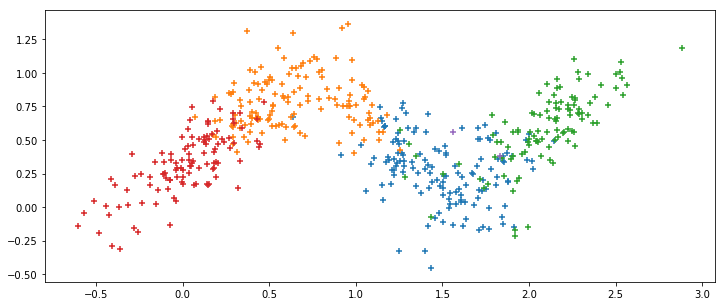

In [14]:
# plot generated data        
plt.figure(figsize=(12, 5))

xs = np.c_[dpm2.x, dpm2.s_hat]

for i in range(dpm2.c_hat+1):
    plt.scatter(xs[xs[:,2]==i][:,0], xs[xs[:,2]==i][:,1], marker="+")
plt.show()

In [15]:
dpm2.n_hat

{0: 139, 1: 140, 2: 108, 3: 111, 4: 2}

In [16]:
seed = 0
n = [10, 10, 10, 10, 10] #各データ数
K = 5 #潜在変数の数
D = 2 #次元

#mu:D次元
mu_true = np.array(
    [[0.5, 0.5],
     [2.5, 0.5],
     [0.5, 2.5],
     [1.8, 1.8],
     [2.5, 2.5]])

#sigma: D×D次元
sigma_true = np.array(
    [[[0.03, 0], [0, 0.03]],
     [[0.05, 0], [0, 0.05]],
     [[0.05, 0], [0, 0.03]],
     [[0.01, 0], [0, 0.01]],
     [[0.04, 0], [0, 0.04]]
    ])

rd.seed(seed)
org_data = None
for i in range(K):
    #k_0 に属するデータを生成
    if org_data is None:
        org_data = np.c_[st.multivariate_normal.rvs(mean=mu_true[i], cov=sigma_true[i], size=n[i]), np.ones(n[i])*i]
        
    #k_1, k_2に属するデータを生成し、結合する
    else:
        tmp_data = np.c_[st.multivariate_normal.rvs(mean=mu_true[i], cov=sigma_true[i], size=n[i]), np.ones(n[i])*i]
        org_data = np.r_[org_data, tmp_data]



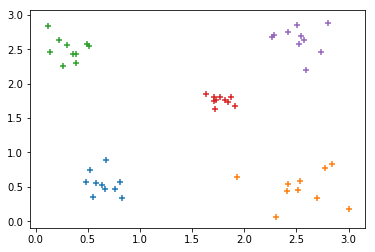

In [17]:
# plot original data        
plt.figure()
for i in range(K):
    plt.scatter(org_data[org_data[:,2]==i][:,0], org_data[org_data[:,2]==i][:,1], marker="+")
plt.show()

In [18]:
x = org_data[:,:2].copy()

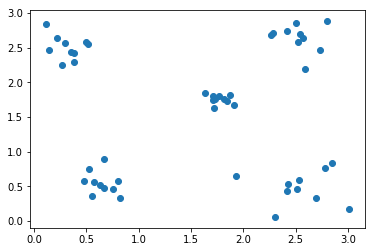

In [19]:
plt.figure()
plt.scatter(x[:,0], x[:,1])
plt.show()

In [20]:
#ハイパーパラメータ
alpha = 1.0
mu0 = np.mean(x, axis=0)#全パターンの平均ベクトル
beta = 0.1
nu = 15
S = np.array([[1, 0],
              [0, 1]])

In [21]:
dpm3 = DPM(x, alpha, mu0, beta, nu, S)

In [22]:
dpm3.update(min_step=1000, stop_count=100)

step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
step: 9
step: 10
step: 11
step: 12
step: 13
step: 14
step: 15
step: 16
step: 17
step: 18
step: 19
step: 20
step: 21
step: 22
step: 23
step: 24
step: 25
step: 26
step: 27
step: 28
step: 29
step: 30
step: 31
step: 32
step: 33
step: 34
step: 35
step: 36
step: 37
step: 38
step: 39
step: 40
step: 41
step: 42
step: 43
step: 44
step: 45
step: 46
step: 47
step: 48
step: 49
step: 50
step: 51
step: 52
step: 53
step: 54
step: 55
step: 56
step: 57
step: 58
step: 59
step: 60
step: 61
step: 62
step: 63
step: 64
step: 65
step: 66
step: 67
step: 68
step: 69
step: 70
step: 71
step: 72
step: 73
step: 74
step: 75
step: 76
step: 77
step: 78
step: 79
step: 80
step: 81
step: 82
step: 83
step: 84
step: 85
step: 86
step: 87
step: 88
step: 89
step: 90
step: 91
step: 92
step: 93
step: 94
step: 95
step: 96
step: 97
step: 98
step: 99
step: 100
step: 101
step: 102
step: 103
step: 104
step: 105
step: 106
step: 107
step: 108
step: 109
step: 110
step: 11

step: 845
step: 846
step: 847
step: 848
step: 849
step: 850
step: 851
step: 852
step: 853
step: 854
step: 855
step: 856
step: 857
step: 858
step: 859
step: 860
step: 861
step: 862
step: 863
step: 864
step: 865
step: 866
step: 867
step: 868
step: 869
step: 870
step: 871
step: 872
step: 873
step: 874
step: 875
step: 876
step: 877
step: 878
step: 879
step: 880
step: 881
step: 882
step: 883
step: 884
step: 885
step: 886
step: 887
step: 888
step: 889
step: 890
step: 891
step: 892
step: 893
step: 894
step: 895
step: 896
step: 897
step: 898
step: 899
step: 900
step: 901
step: 902
step: 903
step: 904
step: 905
step: 906
step: 907
step: 908
step: 909
step: 910
step: 911
step: 912
step: 913
step: 914
step: 915
step: 916
step: 917
step: 918
step: 919
step: 920
step: 921
step: 922
step: 923
step: 924
step: 925
step: 926
step: 927
step: 928
step: 929
step: 930
step: 931
step: 932
step: 933
step: 934
step: 935
step: 936
step: 937
step: 938
step: 939
step: 940
step: 941
step: 942
step: 943
step: 944


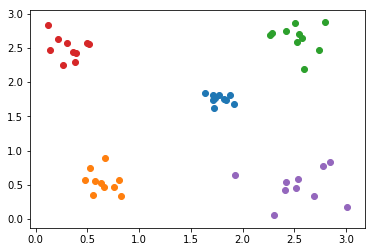

In [23]:
# plot generated data        
plt.figure()

xs = np.c_[dpm3.x, dpm3.s_hat]

for i in range(dpm3.c+1):
    plt.scatter(xs[xs[:,2]==i][:,0], xs[xs[:,2]==i][:,1])
plt.show()